In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
!export http_proxy='10.164.33.254:81'
from wav2vec2 import Wav2vec2
from augmentation.aug import Augment
import os
import IPython.display as ipd
os.environ['http_proxy'] = 'http://10.164.33.254:81'
os.environ['https_proxy'] = 'http://10.164.33.254:81'
w2v = Wav2vec2()
import os
import pandas as pd
import torchaudio
from scipy.io.wavfile import write
import time
import librosa
import utils
import numpy as np
from models import SynthesizerTrn, Generator
from text.symbols import symbols
from torch.nn import functional as F
from mel_processing import mel_spectrogram_torch
from evaluate_v2_test import synthesize, text_to_sequence
from wavlm import WavLM, WavLMConfig
import torch
torch.manual_seed(0)

os.environ["CUDA_VISIBLE_DEVICES"]="3"

Some weights of the model checkpoint at nguyenvulebinh/wav2vec2-large-vi were not used when initializing Wav2Vec2ForPreTraining: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForPreTraining were not initialized from the model checkpoint at nguyenvulebinh/wav2vec2-large-vi and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.origina

In [3]:
hps2 = utils.get_hparams_from_file("./configs/vits_vc.json")
hps2

{'train': {'log_interval': 500, 'eval_interval': 5000, 'save_interval': 5000, 'seed': 1234, 'epochs': 20000, 'optimizer': 'adamw', 'lr_decay_on': True, 'learning_rate': 0.0002, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 16, 'fp16_run': False, 'lr_decay': 0.999875, 'segment_size': 10240, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45, 'c_kl': 1.0, 'aug': True, 'lambda_commit': 0.02}, 'data': {'training_files': 'filelists/train_list_new.txt', 'validation_files': 'filelists/test_list_new.txt', 'text_cleaners': ['english_cleaners2'], 'max_wav_value': 32768.0, 'sampling_rate': 16000, 'filter_length': 1280, 'hop_length': 320, 'win_length': 1280, 'n_mel_channels': 80, 'mel_fmin': 0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 0, 'cleaned_text': True, 'aug_rate': 1.0, 'top_db': 20}, 'model': {'inter_channels': 192, 'hidden_channels': 192, 'filter_channels': 768, 'n_heads': 2, 'n_layers': 6, 'kernel_size': 3, 'p_dropout': 0.1, 'resblock': '1', 'resblock_kernel_sizes': [3, 7, 

In [5]:
aug = Augment(hps2)
checkpoint = torch.load('wavlm/WavLM-Large.pt')
cfg = WavLMConfig(checkpoint['cfg'])
cmodel = WavLM(cfg)
cmodel.load_state_dict(checkpoint['model'])
cmodel.eval()
net_g = SynthesizerTrn(
    len(symbols),
    hps2.data.filter_length // 2 + 1,
    hps2.train.segment_size // hps2.data.hop_length,
    n_speakers=hps2.data.n_speakers,
    **hps2.model)
_ = net_g.eval()
# _ = utils.load_checkpoint("/data/luonghc/vits_vc_aug_logs/G_420000.pth", net_g, None)
# _ = utils.load_checkpoint("/data/luonghc/vits_vc_aug_wavlm_logs/G_375000.pth", net_g, None)
_ = utils.load_checkpoint("/data/luonghc/vits_vc_aug_wavlm_vctk_logs/G_755000.pth", net_g, None)

INFO:wavlm.WavLM:WavLM Config: {'extractor_mode': 'layer_norm', 'encoder_layers': 24, 'encoder_embed_dim': 1024, 'encoder_ffn_embed_dim': 4096, 'encoder_attention_heads': 16, 'activation_fn': 'gelu', 'layer_norm_first': True, 'conv_feature_layers': '[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2', 'conv_bias': False, 'feature_grad_mult': 1.0, 'normalize': True, 'dropout': 0.0, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.0, 'dropout_input': 0.0, 'dropout_features': 0.0, 'mask_length': 10, 'mask_prob': 0.8, 'mask_selection': 'static', 'mask_other': 0.0, 'no_mask_overlap': False, 'mask_min_space': 1, 'mask_channel_length': 10, 'mask_channel_prob': 0.0, 'mask_channel_selection': 'static', 'mask_channel_other': 0.0, 'no_mask_channel_overlap': False, 'mask_channel_min_space': 1, 'conv_pos': 128, 'conv_pos_groups': 16, 'relative_position_embedding': True, 'num_buckets': 320, 'max_distance': 800, 'gru_rel_pos': True}
INFO:root:Loaded checkpoint '/data/luonghc/

In [6]:
# list_ref = os.listdir('audio_paper/seen')
# list_ref = ['FS2.wav', 'FS3.wav', 'MS2.wav', 'MS3.wav']
list_ref = ['FUS2.wav', 'FUS3.wav', 'MUS2.wav', 'MUS3.wav']

In [7]:
wav_src, sr = librosa.load('audio_paper/audio/FUS1.wav', sr=16000)
wav_src = wav_src / abs(wav_src).max() * 0.999
wav_torch = torch.from_numpy(wav_src).unsqueeze(0)
x = utils.get_content(cmodel, wav_torch)
# x = w2v(wav_torch)
print("wav source: ")
ipd.display(ipd.Audio(wav_src, rate=hps2.data.sampling_rate, normalize=True))

for file in list_ref:
    wav, sr = librosa.load(f'audio_paper/audio/{file}', sr=16000)
    # wav = wav[5*320:5*320 + 35840]
    wav = wav / abs(wav).max() * 0.999
    
    mel = mel_spectrogram_torch(
        torch.from_numpy(wav).unsqueeze(0),
        hps2.data.filter_length, 
        hps2.data.n_mel_channels, 
        hps2.data.sampling_rate,
        hps2.data.hop_length,
        hps2.data.win_length,
        hps2.data.mel_fmin, 
        hps2.data.mel_fmax
    )
    print("ref " + file[:-4])
    ipd.display(ipd.Audio(wav, rate=hps2.data.sampling_rate, normalize=True))
    
    result = net_g.infer(x, torch.tensor([x.size(2)]), mel, noise_scale=00)[0,0].data.cpu().float().numpy()
    print("converted: ")
    ipd.display(ipd.Audio(result, rate=hps2.data.sampling_rate, normalize=True))
    # write(f"audio_paper/REVC_vn/FUS1_to_{file[:-4]}.wav", 16000, result) 
    


wav source: 


ref FUS2


converted: 


ref FUS3


converted: 


ref MUS2


converted: 


ref MUS3


converted: 


In [24]:
listfile = os.listdir('audio_paper/audio')
for file in listfile:
    wav, sr = librosa.load(f'audio_paper/audio/{file}', sr=16000)
    wav = wav / abs(wav).max() * 0.999
    write(f'audio_paper/audio/{file}', 16000, wav) 
    

In [14]:
list_ref = os.listdir('MyTam')

wav, sr = librosa.load(f'audio/lai_van_sam.wav', sr=16000)
wav = wav[5*320:5*320 + 35840]
wav = wav / abs(wav).max() * 0.999

mel = mel_spectrogram_torch(
    torch.from_numpy(wav).unsqueeze(0),
    hps2.data.filter_length, 
    hps2.data.n_mel_channels, 
    hps2.data.sampling_rate,
    hps2.data.hop_length,
    hps2.data.win_length,
    hps2.data.mel_fmin, 
    hps2.data.mel_fmax
)[:,:,5:117]
ipd.display(ipd.Audio(wav, rate=hps2.data.sampling_rate, normalize=True))

print("ref " + file[:-4])

for file in list_ref:
    wav_src, sr = librosa.load('MyTam/' + file, sr=16000)
    wav_src = wav_src / abs(wav_src).max() * 0.999
    print("ref ", file)
    ipd.display(ipd.Audio(wav_src, rate=hps2.data.sampling_rate, normalize=True))
    
    wav_torch = torch.from_numpy(wav_src).unsqueeze(0)
    x = utils.get_content(cmodel, wav_torch)  
    
    result = net_g.infer(x, torch.tensor([x.size(2)]), mel, noise_scale=00)[0,0].data.cpu().float().numpy()
    print("converted: ")
    ipd.display(ipd.Audio(result, rate=hps2.data.sampling_rate, normalize=True))
    save_audio(torch.from_numpy(result), None, "/data/luonghc/vits_vc_aug/result/MyTam/" + file.replace('.wav', '_converted.wav'))   


ref MyTam
ref  MyTam.wav


converted: 


ref  MyTam_5db.wav


converted: 


ref  MyTam_10db.wav


converted: 


ref  MyTam_15db.wav


converted: 


ref  MyTam_20db.wav


converted: 


In [11]:
from scipy.io.wavfile import write
def save_audio(wav, silences, out_file, syn_sr=16000):
    wav = (wav.squeeze() / wav.abs().max() * 0.999 * 32767.0).cpu().numpy().astype('int16')

    if silences:
        for s in silences:
            temp = np.array([0]*(s[1]-s[0]), dtype=np.int16)
            wav = np.concatenate((wav[:s[0]], temp, wav[s[0]:]))

    write(out_file, syn_sr, wav) 

In [237]:
wav, sr = librosa.load('/data/luonghc/viVoice_padded/audio_816.63_821.99.wav', sr=16000)
# wav = wav / abs(wav).max() * 0.999
wav_torch = torch.from_numpy(wav).unsqueeze(0)
# x.shape
print(wav_torch.shape)
aug_x = aug(wav_torch)
print(aug_x.shape)
x_pad = F.pad(aug_x, (40, 40), "reflect")
temp = x_pad.squeeze(0).cpu().numpy()
print(x_pad.shape)
x = w2v(x_pad.cuda())

# plt.plot(x_pad)
# plt.plot(wav_torch.squeeze(0).cpu().numpy())
x.shape

torch.Size([1, 85760])
torch.Size([1, 85760])
torch.Size([1, 85840])


torch.Size([1, 1024, 268])

In [50]:
import wenet

model = wenet.load_model('chinese')
result = model.transcribe('audio.wav')
print(result['text'])

ModuleNotFoundError: No module named 'wenet'

In [20]:
def load_audio_to_torch(audio_path):
    audio, sample_rate = torchaudio.load(audio_path)
    audio = audio / abs(audio).max() * 0.999
    return audio.squeeze(), sample_rate
wav1, sr = load_audio_to_torch('/data/luonghc/viVoice/audio_142.66_149.94.wav')
wav2, sr = load_audio_to_torch('/data/luonghc/viVoice_sr/audio_142.66_149.94_70.wav')
# while True:
#     aug_x = aug(wav.unsqueeze(0))
#     if abs(aug_x).max() <= 1:
#         break
# nan_x = torch.isnan(aug_x).any()
# x = x if nan_x else aug_x
x_pad1 = F.pad(wav1.unsqueeze(0), (40, 40), "reflect")
x_pad2 = F.pad(wav2.unsqueeze(0), (40, 40), "reflect")
x1 = w2v(x_pad1)
x2 = w2v(x_pad2)
print(x_pad1.shape)
print(x_pad2.shape)
print(x1.shape)
print(x2.shape)

torch.Size([1, 120230])
torch.Size([1, 120081])
torch.Size([1, 1024, 375])
torch.Size([1, 1024, 375])


168

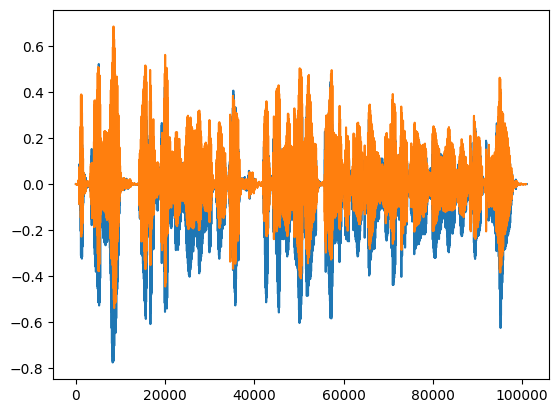

In [9]:
import librosa
wav1, sr = librosa.load('/data/luonghc/viVoice/audio_257.65_263.83.wav', sr=16000)
wav2, sr = librosa.load('/data/luonghc/viVoice_sr/audio_257.65_263.83_68.wav', sr=16000)
plt.plot(wav1)
plt.plot(wav2)
len(wav1) - len(wav2)

In [164]:
import torch.nn as nn
emb = nn.Embedding(4, 12)
a = torch.tensor([1,2,3])
print(a.shape)
out = emb(a)
print(out.shape)
out2 = out.view(3, 1, -1)
print(out2.shape)

torch.Size([3])
torch.Size([3, 12])
torch.Size([3, 1, 12])


In [179]:
torch.nn.functional.softmax(torch.tensor([[-1.1389, -1.2024, -0.9693],
        [-1.1065, -1.2200, -0.9834],
        [-1.1286, -1.2093, -0.9726],
        [-1.1190, -1.1960, -0.9916],
        [-1.0137, -1.2642, -1.0366]]))

/tmp/ipykernel_41972/11935741.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(torch.tensor([[-1.1389, -1.2024, -0.9693],


tensor([[0.3202, 0.3005, 0.3794],
        [0.3307, 0.2952, 0.3740],
        [0.3235, 0.2984, 0.3781],
        [0.3266, 0.3024, 0.3710],
        [0.3629, 0.2825, 0.3547]])

In [264]:
ii = temp > 1
iii = temp < -1
temp[ii] = 1
temp[iii] = -1

In [ ]:
wav = np.load('test.npy')
wav[0].shape
for i in range(8):
    ipd.display(ipd.Audio(wav[i], rate=16000, normalize=True))


In [29]:
spec = torch.load('/data/luonghc/viVoice/' + listfile[0])
spec.shape

torch.Size([513, 460])

In [ ]:
import torch
import os

listfile = os.listdir('/data/luonghc/viVoice_spec')
print(len(listfile))
for file in listfile:
    try:
        spec = torch.load('/data/luonghc/viVoice_spec/' + file)
        print(spec.shape)
        if spec.shape[1] <= 120:
            print(":1")
        if len(spec.shape) >2 :
            print("21")
    except:
        print(file)

tensor(2.6129, grad_fn=<NllLossBackward0>)

### Wav2vec2

In [7]:
from wav2vec2 import Wav2vec2
import os
import pandas as pd
import librosa
import torch
os.environ['http_proxy'] = 'http://10.40.34.14:81'
os.environ['https_proxy'] = 'http://10.40.34.14:81'
w2v = Wav2vec2().cuda()

DEBUG:urllib3.connectionpool:Resetting dropped connection: huggingface.co
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/model.safetensors HTTP/1.1" 404 0


Some weights of the model checkpoint at nguyenvulebinh/wav2vec2-large-vi were not used when initializing Wav2Vec2ForPreTraining: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForPreTraining were not initialized from the model checkpoint at nguyenvulebinh/wav2vec2-large-vi and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.origina

In [8]:
df = pd.read_csv('filelists/train_list_new.txt', header=None, delimiter='|')
df

0    1
0       /data/luonghc/viVoice/audio_104.32_107.14.wav  # a
1       /data/luonghc/viVoice/audio_641.74_648.68.wav  # a
2       /data/luonghc/viVoice/audio_613.06_617.18.wav  # a
3         /data/luonghc/viVoice/audio_16.92_21.38.wav  # a
4        /data/luonghc/viVoice/audio_649.96_657.5.wav  # a
...                                               ...  ...
199995   /data/luonghc/viVoice/audio_317.24_322.9.wav  # a
199996  /data/luonghc/viVoice/audio_317.26_322.22.wav  # a
199997  /data/luonghc/viVoice/audio_317.27_326.93.wav  # a
199998  /data/luonghc/viVoice/audio_317.28_321.36.wav  # a
199999  /data/luonghc/viVoice/audio_317.28_322.22.wav  # a

[200000 rows x 2 columns]

In [10]:
wav = librosa.core.load('/data/luonghc/viVoice/audio_104.32_107.14.wav', sr=16000)[0]
audio_norm = wav / abs(wav).max() * 0.999
audio_norm = torch.tensor(audio_norm).unsqueeze(0)
audio_norm.shape

torch.Size([1, 49153])

In [6]:

# wav, sr = librosa.load('/data/luonghc/viVoice/audio_228.16_231.6.wav', sr=16000)
# wav_torch = torch.from_numpy(wav).unsqueeze(0).unsqueeze(0).cuda()

# aug_x = aug(wav_torch.squeeze(1))
# x_pad = F.pad(wav_torch, (40, 40), "reflect")
# x = w2v(x_pad)
# # 

# ipd.display(ipd.Audio(aug_x.cpu().numpy(), rate=hps2.data.sampling_rate, normalize=True))
# x
# x.shape
35840/320

112.0

In [30]:
wav = librosa.core.load('/data/luonghc/viVoice/audio_104.32_107.14.wav', sr=16000)[0]
audio_norm = wav / abs(wav).max() * 0.999
audio_norm = torch.tensor(audio_norm[:35840]).unsqueeze(0)
audio_norm.shape

torch.Size([1, 35840])

In [34]:
from mel_processing import spectrogram_torch, spec_to_mel_torch
audio_norm = torch.tensor(wav[:35840]).unsqueeze(0)
spec = spectrogram_torch(audio_norm, hps.data.filter_length,
                hps.data.sampling_rate, hps.data.hop_length, hps.data.win_length,
                center=False)
mel = spec_to_mel_torch(
        spec, 
        hps.data.filter_length, 
        hps.data.n_mel_channels, 
        hps.data.sampling_rate,
        hps.data.mel_fmin, 
        hps.data.mel_fmax)

print(spec.shape)
print(mel.shape)
spec = spectrogram_torch(audio_norm, 400,
                hps.data.sampling_rate, 160, 400,
                center=False)
print(spec.shape)


torch.Size([1, 641, 112])
torch.Size([1, 80, 112])
torch.Size([1, 201, 224])


In [22]:
filename = '/data/luonghc/viVoice/audio_317.26_322.22.wav'
wav = librosa.core.load(filename, sr=16000)[0]
audio_norm = wav / abs(wav).max() * 0.999
audio_norm = torch.tensor(audio_norm).unsqueeze(0)
spec_filename = filename.replace(".wav", ".spec.pt").replace('/viVoice/', '/viVoice_spec_vits_vc/')
spec = torch.load(spec_filename)
print(audio_norm.shape)
print(spec.shape)

torch.Size([1, 80556])
torch.Size([641, 251])


In [142]:
5*320

1600

In [141]:
import random
min_idx = 1
max_idx = spec.size(1) - 1 - 112
index = random.randint(min_idx, max_idx)
new_spec = spec[:, index:index+112]
new_wav = audio_norm[:, index*320:index*320+35840]
print(new_spec.shape)
print(new_wav.shape)

torch.Size([641, 112])
torch.Size([1, 35840])


torch.Size([1, 35840])

In [6]:
import librosa
import os
import pandas as pd
import audio_util as audio
import numpy as np
file = '/data/luonghc/viVoice/audio_748.95_753.01.wav'
wav, sr = librosa.load(file, sr=16000)
dur = librosa.get_duration(filename=file)
print(dur)
x = os.path.getsize(file) // (2 * 320)
x

4.0960625


204

In [6]:
os.path.getsize('/data/luonghc/viVoice/audio_170.56_178.26.wav')

245804

In [29]:
df = pd.read_csv('/data/luonghc/vits_final3/zalotts-v2/zalo_tts/vits/filelists/train_list_new.txt', header=None, delimiter='|')
for i in range(len(df)):
    x = os.path.getsize(df[0][i]) // (2 * 320)
    if x < 200:
        continue
    wav, sr = librosa.load(df[0][i], sr=16000)

    n_fft = 1280
    frame_shift_ms = None
    audio_norm = audio.trim_silence(wav, n_fft, hps2.data.sampling_rate, hps2.data.hop_length, frame_shift_ms)
    silence = np.zeros(1 * audio.get_hop_size(hps2.data.sampling_rate, hps2.data.hop_length, frame_shift_ms))
    audio_norm = np.concatenate((silence, audio_norm, silence))
    
    if len(wav) < 35840:
        print(df[0][i])

In [30]:
import torch
from torch.nn import functional as F
a = torch.rand(8, 80, 112)
b = torch.rand(8, 80, 112)
loss_mel = F.l1_loss(a, a)
loss_mel

tensor(0.)

In [8]:
import torch.nn as nn
import modules
import commons
class ContentEncoder(nn.Module):
  def __init__(self,
      out_channels,
      hidden_channels,
      kernel_size,
      dilation_rate,
      n_layers,
      gin_channels=0):
    super().__init__()
    self.out_channels = out_channels
    self.hidden_channels = hidden_channels
    self.kernel_size = kernel_size
    self.dilation_rate = dilation_rate
    self.n_layers = n_layers
    self.gin_channels = gin_channels

    self.pre = nn.Conv1d(1024, hidden_channels, 1) # add weight_norm
    self.enc = modules.WN(hidden_channels, kernel_size, dilation_rate, n_layers, gin_channels=gin_channels)
    self.proj = nn.Conv1d(hidden_channels, out_channels * 2, 1)

  def forward(self, x, x_lengths, g=None):
    x_mask = torch.unsqueeze(commons.sequence_mask(x_lengths, x.size(2)), 1).to(x.dtype)
    x = self.pre(x) * x_mask
    x = self.enc(x, x_mask, g=g)
    stats = self.proj(x) * x_mask
    m, logs = torch.split(stats, self.out_channels, dim=1)
    z = (m + torch.randn_like(m) * torch.exp(logs)) * x_mask
    return m

content = ContentEncoder(192, 192, 5, 1, 16, gin_channels=256).cuda()

/data/miniconda3/envs/freevc/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [12]:
g = torch.rand(1, 256, 1).cuda()

In [13]:
temp = torch.tensor([[[float('nan')]]])

torch.isnan(temp[0,0,0]) == True

tensor(True)

In [14]:
import pandas as pd
from tqdm import tqdm
df = pd.read_csv('/data/luonghc/vits_final/zalotts-v2/zalo_tts/vits/filelists/train_list_new.txt', header=None, delimiter='|')
for i in tqdm(range(41826, len(df))):
    wav, sr = librosa.load(df[0][i], sr=16000)
    wav_torch = torch.from_numpy(wav).unsqueeze(0).unsqueeze(0).cuda()
    
    aug_x = aug(wav_torch.squeeze(1))
    x_pad = F.pad(wav_torch, (40, 40), "reflect")
    x = w2v(x_pad)
    temp = content(x, torch.tensor([x.size(2)]).cuda(), g)

    if torch.isnan(temp[0,0,0]):
        print(df[0][i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137092/137092 [49:19<00:00, 46.32it/s]


In [106]:
content(spec, torch.tensor([spec.size(2)]), g)

tensor([[[-0.0938, -0.0663, -0.0316,  ..., -0.5317, -0.0180,  0.7304],
         [-0.0182,  0.0103,  0.0165,  ..., -0.5978, -0.6065,  0.0992],
         [ 0.5386,  0.5126,  0.5218,  ..., -0.0693,  0.2301,  0.6087],
         ...,
         [-0.0091, -0.0212,  0.0054,  ...,  0.6596, -0.1177,  0.8984],
         [-0.0893, -0.0671, -0.0801,  ...,  0.6738, -0.2200,  0.5855],
         [-0.0495, -0.0598, -0.0114,  ...,  1.2548,  1.3365,  0.1602]]],
       grad_fn=<SplitBackward0>)

In [95]:
content(x*10000, torch.tensor([spec.size(2)]), g)

tensor([[[ 0.0543, -1.7184, -0.5437,  ..., -1.5781, -1.0354, -1.0228],
         [-0.0840, -0.1846, -0.8642,  ..., -0.3837, -0.9467,  0.6643],
         [ 2.2417,  1.2780,  0.2416,  ...,  2.4862,  1.2949,  2.9827],
         ...,
         [ 1.2680,  0.0448,  0.9223,  ...,  0.5768,  1.1291,  0.5313],
         [ 1.9577,  0.2145,  0.9542,  ...,  0.0421,  0.3149,  0.9683],
         [-0.1552, -0.8669, -0.3430,  ...,  0.4935,  1.0877,  0.1138]]],
       grad_fn=<SplitBackward0>)

### Inference

In [44]:
import pandas as pd
import os
df = pd.read_csv('filelists/vctk.txt', header=None, delimiter='|')
lengths = []
for i in range(len(df)):
    lengths.append(os.path.getsize(df[0][i]) // (4 * 320))

In [51]:
bin_150_300 = 0
bin_300_400 = 0
bin_400_500 = 0
bin_500_600 = 0
bin_600_700 = 0
bin_700_800 = 0
bin_800_900 = 0
bin_900_1000 = 0
bin_1000_1100 = 0
bin_1000 = 0
for l in lengths:
    if l >= 72 and l < 300: bin_150_300 += 1
    elif l >= 300 and l < 400: bin_300_400 += 1
    elif l >= 400 and l < 500: bin_400_500 += 1
    elif l >= 500 and l < 600: bin_500_600 += 1
    elif l >= 600 and l < 700: bin_600_700 += 1
    elif l >= 700 and l < 800: bin_700_800 += 1
    elif l >= 800 and l < 900: bin_800_900 += 1
    elif l >= 900 and l < 1000: bin_900_1000 += 1
    elif l >= 1000 and l < 1100: bin_1000_1100 += 1
    elif l >= 1000: bin_1000 += 1
print(bin_150_300)
print(bin_300_400)
print(bin_400_500)
print(bin_500_600)
print(bin_600_700)
print(bin_700_800)
print(bin_800_900)
print(bin_900_1000)
print(bin_1000_1100)
print(bin_1000)

42055
1552
431
108
51
11
3
1
0
0


In [49]:
320 * 64

20480

In [43]:
for i in range(len(df)):
    file = df[0][i]
    length = os.path.getsize(df[0][i]) // (4 * 320)
    wav, sr = librosa.load(file, sr=16000)
    wav = wav[5*320:5*320 + 35840]
    wav = wav / abs(wav).max() * 0.999
    
    mel = mel_spectrogram_torch(
        torch.from_numpy(wav).unsqueeze(0),
        hps2.data.filter_length, 
        hps2.data.n_mel_channels, 
        hps2.data.sampling_rate,
        hps2.data.hop_length,
        hps2.data.win_length,
        hps2.data.mel_fmin, 
        hps2.data.mel_fmax
    )
    print(length)
    print(mel.shape)
    if i == 10:
        break

102
torch.Size([1, 80, 102])
202
torch.Size([1, 80, 202])
390
torch.Size([1, 80, 390])
220
torch.Size([1, 80, 220])
326
torch.Size([1, 80, 326])
388
torch.Size([1, 80, 388])
309
torch.Size([1, 80, 309])
403
torch.Size([1, 80, 403])
279
torch.Size([1, 80, 279])
177
torch.Size([1, 80, 177])
467
torch.Size([1, 80, 467])


In [2]:
import shutil
import pandas as pd
df = pd.read_csv('filelists/train_list_test.txt', header=None, delimiter='|')
df

0  1
0  /data/luonghc/viVoice/audio_104.32_107.14.wav  a
1  /data/luonghc/viVoice/audio_641.74_648.68.wav  a
2  /data/luonghc/viVoice/audio_613.06_617.18.wav  a
3    /data/luonghc/viVoice/audio_16.92_21.38.wav  a
4   /data/luonghc/viVoice/audio_649.96_657.5.wav  a
5  /data/luonghc/viVoice/audio_405.73_410.03.wav  a
6  /data/luonghc/viVoice/audio_557.88_564.72.wav  a
7    /data/luonghc/viVoice/audio_10.42_14.32.wav  a
8  /data/luonghc/viVoice/audio_125.82_129.28.wav  a
9  /data/luonghc/viVoice/audio_685.62_690.78.wav  a

In [4]:
for i in range(len(df)):
    src = df[0][i].replace(".wav", ".spec.pt").replace('/viVoice/', '/viVoice_spec/')
    dst = df[0][i].replace(".wav", ".spec.pt").replace('/viVoice/', '/viVoice_spec_test/')
    shutil.copyfile(src, dst)

### Training

In [11]:
import os
import json
import argparse
import itertools
import math
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.cuda.amp import autocast, GradScaler

from augmentation.aug import Augment
from wav2vec2 import Wav2vec2
import commons
import utils
from data_utils import (
  TextAudioSpeakerLoader,
  TextAudioSpeakerCollate,
  DistributedBucketSampler
)
from models import (
  SynthesizerTrn,
  MultiPeriodDiscriminator,
)
from losses import (
  generator_loss,
  discriminator_loss,
  feature_loss,
  kl_loss
)
from mel_processing import mel_spectrogram_torch, spec_to_mel_torch
from text.symbols import symbols

os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['http_proxy'] = "http://10.40.34.14:81" 
os.environ['https_proxy'] = "http://10.40.34.14:81" 

In [12]:
hps = utils.get_hparams_from_file("./configs/vits_vc.json")

w2v = Wav2vec2().cuda(0)
aug = Augment(hps).cuda(0)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /nguyenvulebinh/wav2vec2-large-vi/resolve/main/model.safetensors HTTP/1.1" 404 0


Some weights of the model checkpoint at nguyenvulebinh/wav2vec2-large-vi were not used when initializing Wav2Vec2ForPreTraining: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForPreTraining from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForPreTraining were not initialized from the model checkpoint at nguyenvulebinh/wav2vec2-large-vi and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.origina

In [7]:
train_dataset = TextAudioSpeakerLoader(hps.data.training_files, hps.data)
train_sampler = DistributedBucketSampler(
  train_dataset,
  hps.train.batch_size,
  [150,300,400,500,600,800],
  num_replicas=1,
  rank=0,
  shuffle=True)
collate_fn = TextAudioSpeakerCollate()
train_loader = DataLoader(train_dataset, num_workers=64, shuffle=False, pin_memory=True,
  collate_fn=collate_fn, batch_sampler=train_sampler)

----------------------------------------
==> NUM OF SAMPLE FOR TRAINING:  429936
----------------------------------------


In [26]:
from wavlm import WavLM, WavLMConfig
checkpoint = torch.load('wavlm/WavLM-Large.pt')
cfg = WavLMConfig(checkpoint['cfg'])
cmodel = WavLM(cfg).cuda()
cmodel.load_state_dict(checkpoint['model'])
cmodel.eval()
cfg

INFO:wavlm.WavLM:WavLM Config: {'extractor_mode': 'layer_norm', 'encoder_layers': 24, 'encoder_embed_dim': 1024, 'encoder_ffn_embed_dim': 4096, 'encoder_attention_heads': 16, 'activation_fn': 'gelu', 'layer_norm_first': True, 'conv_feature_layers': '[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2', 'conv_bias': False, 'feature_grad_mult': 1.0, 'normalize': True, 'dropout': 0.0, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.0, 'dropout_input': 0.0, 'dropout_features': 0.0, 'mask_length': 10, 'mask_prob': 0.8, 'mask_selection': 'static', 'mask_other': 0.0, 'no_mask_overlap': False, 'mask_min_space': 1, 'mask_channel_length': 10, 'mask_channel_prob': 0.0, 'mask_channel_selection': 'static', 'mask_channel_other': 0.0, 'no_mask_channel_overlap': False, 'mask_channel_min_space': 1, 'conv_pos': 128, 'conv_pos_groups': 16, 'relative_position_embedding': True, 'num_buckets': 320, 'max_distance': 800, 'gru_rel_pos': True}


In [24]:
import librosa

def get_content(cmodel, y):
    with torch.no_grad():
        c = cmodel.extract_features(y.squeeze(1))[0]
    c = c.transpose(1, 2)
    return c

wav, _ = librosa.load("audio/AnhDanh.wav", sr=16000)
wav = torch.from_numpy(wav).unsqueeze(0).cuda()
c = get_content(cmodel, wav)
wav.shape

torch.Size([1, 59595])

In [38]:
for batch_idx, (x, x_lengths, spec, spec_lengths, y, y_lengths) in enumerate(train_loader):
    y, y_lengths = y.cuda(0, non_blocking=True), y_lengths.cuda(0, non_blocking=True)
    print(y.shape)
    aug_x_temp = aug(y.squeeze(1))
    nan_x = torch.isnan(aug_x_temp).any()
    aug_x = y.squeeze(1) if nan_x else aug_x_temp
    print(aug_x.shape)
    
    x_pad = F.pad(aug_x, (40, 40), "reflect")
    print(x_pad.shape)
    
    w2v_x = w2v(x_pad)
    print(x_pad.shape)
    print("w2v_x: ", w2v_x.shape)
    c = get_content(cmodel, x_pad)
    print("c: ", c.shape)
    
    
    break

torch.Size([16, 1, 35840])
torch.Size([16, 35840])
torch.Size([16, 35920])
torch.Size([16, 35920])
w2v_x:  torch.Size([16, 1024, 112])
c:  torch.Size([16, 1024, 112])


### Prepare data VCTK

In [26]:
from glob import glob
import librosa
from scipy.io.wavfile import write

In [41]:
listfile = glob('/data/luonghc/VCTK-Corpus/wav48/*/*.wav')

In [5]:
f = open("filelists/vctk.txt", "a")

for file in listfile:
    f.write(file + '\n')
f.close()

In [28]:
for file in listfile:
    wav, sr = librosa.load(file)
    new_wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
    write(file, 16000, new_wav)

In [14]:
import pandas as pd
import os
df = pd.read_csv('/data/luonghc/vits_vc_aug/filelists/vctk.txt', header=None, delimiter='|')
for i in range(len(df)):
    spec_file = df[0][i].replace(".wav", ".spec.pt")
    if os.path.isfile(spec_file):
        os.remove(spec_file)